In [1]:
%pwd

'/home/ironchefsands/Documents/dynamic model'

In [2]:
%ls

Hood1DG_v1.ipynb  hood1D.ipynb  model_b_v1.ipynb  Untitled.ipynb


In [83]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Gang:
    """
    z: sites
    n: turns
    alpha: gang's propensity to crime
    g:  initial gang population at each site
    s:  gang concentration at each site
    """
    def __init__(self, z=2, n=10, alpha = 0.1, g = None, s=None):
        self.z = z
        self.n = n
        self.alpha = alpha
        
        self.g = np.zeros(z) if g is None else g
        self.s = np.ones(z) if s is None else s
        # initialize grid
        self.G = np.zeros((n,z))
        self.G[0] = self.g
        
    def draw(self):
        a = self.G
        plt.imshow(a, cmap='magma', alpha=0.7)
        plt.xticks([])
        plt.yticks([])
        
    def graph(self):
        G = self.G
        z = self.z
        n = self.n
        colors = 'brgcmyk'
        fig, ax = plt.subplots()
        for i in range(z):
            ax.plot(range(n), G[:, i], '-' + colors[i % len(colors)])
        
class Hood1DG:
    """
    z: sites
    n: turns
    gang_count: number of gangs in hood
    gang_list: optional list of gang objects
    p: police presence in each site
    beta: arrest rate
    gamma: police reactivity
    delta: violence coefficient
    """
    def __init__(self, z=2, n=10, gang_count=2, gang_list=None,
                 p=None, beta=0.01, gamma=0.5, delta=0.5):
        self.z = z
        self.n = n
        self.gang_count = gang_count
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        
        self.p = np.ones(z) if p is None else p
        
        # initialize grids:
        # police
        self.P = np.zeros((n, z))
        # crime
        self.C = np.zeros((n, z))
        # arrests
        self.A = np.zeros((n, z))
        # violence
        self.V = np.zeros((n, z))
        
        # initialize gang list
        if gang_list is None:
            self.gangs = []
            for i in range(gang_count):
                self.gangs.append(Gang(z, n))
        else:
            self.gangs = gang_list
            
        # initial conditions
        # police
        self.P[0] = self.p
        # crime at site = sum(gang pop. * gang alpha)
        for k in range(gang_count):
            self.C[0] += self.gangs[k].G[0] * self.gangs[k].alpha
            
        self.t = 0
        
    def step(self):
        t = self.t
        # reduce gang populations by arrests
        for k in range(self.gang_count):
            gang = self.gangs[k]
            arrests = self.beta * gang.G[t] * self.P[t]
            self.A[t] += arrests
            gang.G[t+1] = gang.G[t] - arrests
        # account for movement between sites
        for k in range(self.gang_count):
            gang = self.gangs[k]
            g_ = gang.G[t+1].copy()
            gang.G[t+1] *= 0
            for i in range(self.z):
                gang.G[t+1] += g_[i] * self.PI_k_ij(k,i)
        
        # add source terms
        for k in range(self.gang_count):
            gang = self.gangs[k]
            gang.G[t+1] += gang.s
        # update crime grid based on gang figures
        # just calculated
        for k in range(self.gang_count):
            gang = self.gangs[k]
            self.C[t+1] += gang.G[t+1] * gang.alpha
        # update police numbers
        self.P[t+1] = self.P[t] + self.gamma * self.C[t]
            
        self.t += 1
        
    def PI_k_ij(self, k, i):
        """ 
        transition function: 
        For gang k at site i, returns array of
        length z containing probabilities of transition
        from i to each site
        """
        t = self.t
        # count rival gang members in each site
        rivals = np.zeros(self.z)
        for l in range(self.gang_count):
            if l != k:
                rivals += self.gangs[l].G[t]
        # compute difference of (cops + rivals) between
        # i and every site
        p_ = self.P[t]
        x = (p_[i] + rivals[i]) - (p_ + rivals)
        # find ln(1+e^x) for each entry
        x = np.log(1 + np.exp(x))
        return x / x.sum()
        
        
    def loop(self):
        for i in range(self.n - 1):
            self.step()
            
    def draw(self):
        crime = self.C
        plt.imshow(crime, cmap='plasma')
        plt.xticks([])
        plt.yticks([])
        
    def graph(self):
        crime = self.C
        z = self.z
        n = self.n
        colors = 'brgcmyk'
        fig, ax = plt.subplots()
        for i in range(z):
            ax.plot(range(n), crime[:, i], '-' + colors[i % len(colors)])

In [85]:
hood = Hood1DG()

In [86]:
# check conservation of mass
bloods = Gang(z=5, n=20, alpha=0.1, g=np.array([1,6,1,0,1]), s=np.array([0, 0, 0, 0, 0]))
crips = Gang(z=5, n=20, alpha=0.3, g=np.array([1,0,4,1,1]), s=np.array([0, 0, 0, 0, 0]))
hood= Hood1DG(z=5,n=20, gang_count=2, gang_list=[bloods, crips], p=np.array([1,1,1,1,1]), beta=0.0, gamma=0.5)

In [87]:
hood.loop()

In [88]:
bloods.G

array([[1.        , 6.        , 1.        , 0.        , 1.        ],
       [1.76123068, 3.57209239, 0.14421558, 1.76123068, 1.76123068],
       [1.6582662 , 3.91300415, 1.1767138 , 0.59374964, 1.6582662 ],
       [1.75742586, 3.60088049, 0.36951534, 1.51475245, 1.75742586],
       [1.72502663, 3.92470632, 1.00772342, 0.61751699, 1.72502663],
       [1.70141721, 3.89303422, 0.4708888 , 1.23324256, 1.70141721],
       [1.6972712 , 4.15168558, 0.86331508, 0.59045694, 1.6972712 ],
       [1.61097095, 4.28153147, 0.52710233, 0.9694243 , 1.61097095],
       [1.60704555, 4.47214955, 0.75796075, 0.55579859, 1.60704555],
       [1.4930782 , 4.67311592, 0.56762465, 0.77310303, 1.4930782 ],
       [1.47374337, 4.81808105, 0.69741206, 0.53702015, 1.47374337],
       [1.35690619, 5.01348077, 0.60661489, 0.66609196, 1.35690619],
       [1.31967815, 5.13302968, 0.68027438, 0.54733965, 1.31967815],
       [1.21344552, 5.28714462, 0.65016411, 0.63580023, 1.21344552],
       [1.16585255, 5.38430249, 0.

In [89]:
bloods.G.sum(axis=1)

array([9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9.])

In [90]:
crips.G

array([[1.        , 0.        , 4.        , 1.        , 1.        ],
       [1.41495969, 0.01336644, 1.41495969, 2.74175449, 1.41495969],
       [1.29549989, 0.24912207, 2.81490547, 1.34497269, 1.29549989],
       [1.37762848, 0.20231316, 1.49564696, 2.54678292, 1.37762848],
       [1.3796308 , 0.30469843, 2.40754239, 1.52849758, 1.3796308 ],
       [1.37265414, 0.23841622, 1.58336914, 2.43290636, 1.37265414],
       [1.43487227, 0.26144002, 2.1675597 , 1.70125575, 1.43487227],
       [1.40215979, 0.21234599, 1.6509286 , 2.33240582, 1.40215979],
       [1.49142988, 0.19408157, 1.98903301, 1.83402565, 1.49142988],
       [1.46788056, 0.16569353, 1.68324869, 2.21529666, 1.46788056],
       [1.56477999, 0.13875788, 1.84780499, 1.88387715, 1.56477999],
       [1.56366088, 0.12241334, 1.67792023, 2.07234467, 1.56366088],
       [1.65610181, 0.1018539 , 1.73830674, 1.84763574, 1.65610181],
       [1.67279928, 0.09125191, 1.64505949, 1.91809005, 1.67279928],
       [1.75202893, 0.07848372, 1.

In [91]:
crips.G.sum(axis=1)

array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7.])

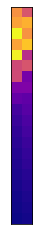

In [92]:
bloods = Gang(2, 20, 0.1, np.ones(2), np.ones(2))
crips = Gang(z=2, n=20, alpha=0.3, g=np.array([5, 4]), s=np.array([1, 1]))
hood = Hood1DG(z=2, n=20, gang_count=2, gang_list=[bloods, crips], p=np.array([1,1]), beta=0.1, gamma=0.5)
hood.loop()
hood.draw()

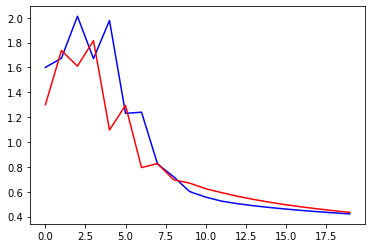

In [93]:
hood.graph()